In [2]:
import cv2
import numpy as np
import os
import tkinter as tk
from tkinter import filedialog, messagebox
from tkinter.ttk import Progressbar
from IPython.display import display, Video

def select_video():
    root = tk.Tk()
    root.withdraw()  # Hide the main window
    filepath = filedialog.askopenfilename(
        title="Select a video file",
        filetypes=[("Video files", "*.mp4 *.avi *.mov *.mkv")]
    )
    return filepath

def process_video(video_path, output_path='output_video.mp4', progress_callback=None):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error opening video file")
        return None

    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    ret, background = cap.read()
    if not ret:
        print("Error reading first frame")
        return None

    background_gray = cv2.cvtColor(background, cv2.COLOR_BGR2GRAY)
    h, w = background_gray.shape[:2]
    frame_idx = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Optical flow calculation
        flow = cv2.calcOpticalFlowFarneback(
            background_gray, frame_gray, None,
            0.5, 5, 25, 5, 7, 1.5, 0
        )

        y, x = np.mgrid[0:h, 0:w].astype(np.float32)
        remap_x = x + flow[..., 0]
        remap_y = y + flow[..., 1]
        aligned_bg = cv2.remap(background, remap_x, remap_y, cv2.INTER_LINEAR)

        # Difference and mask generation
        diff = cv2.absdiff(frame, aligned_bg)
        gray_diff = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
        gray_diff = cv2.GaussianBlur(gray_diff, (5, 5), 0)
        _, threshold = cv2.threshold(gray_diff, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        kernel = np.ones((7, 7), np.uint8)
        threshold = cv2.morphologyEx(threshold, cv2.MORPH_OPEN, kernel, iterations=2)
        threshold = cv2.morphologyEx(threshold, cv2.MORPH_CLOSE, kernel, iterations=3)

        contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        mask = np.zeros_like(threshold)
        for cnt in contours:
            if cv2.contourArea(cnt) > 500:
                cv2.drawContours(mask, [cnt], -1, 255, -1)

        mask = cv2.GaussianBlur(mask, (5, 5), 0)
        _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
        mask_inv = cv2.bitwise_not(mask)

        result = cv2.bitwise_and(aligned_bg, aligned_bg, mask=mask_inv)
        foreground = cv2.bitwise_and(frame, frame, mask=mask)
        final_output = cv2.add(result, foreground)
        out.write(final_output)

        if frame_idx % 10 == 0:
            background = cv2.bitwise_and(background, background, mask=mask_inv)
            new_bg_part = cv2.bitwise_and(frame, frame, mask=mask)
            background = cv2.add(background, new_bg_part)
            background_gray = cv2.cvtColor(background, cv2.COLOR_BGR2GRAY)

        frame_idx += 1
        if progress_callback:
            progress_callback(frame_idx, frame_count)

    cap.release()
    out.release()
    return output_path

def run_app():
    def start_processing():
        video_path = select_video()
        if not video_path:
            messagebox.showwarning("No File", "Please select a video file.")
            return

        progress["maximum"] = 100
        status_label.config(text="Processing...")

        def update_progress(current, total):
            percent = int((current / total) * 100)
            progress["value"] = percent
            window.update_idletasks()

        output_path = process_video(video_path, progress_callback=update_progress)
        status_label.config(text="Done!")
        messagebox.showinfo("Success", f"Processed video saved as: {output_path}")
        display(Video(output_path, embed=True))

    window = tk.Tk()
    window.title("Invisibility Cloak Processor")
    window.geometry("400x200")

    tk.Label(window, text="Invisibility Cloak Video Processor", font=("Helvetica", 14)).pack(pady=10)
    tk.Button(window, text="Select & Process Video", command=start_processing, width=30).pack(pady=10)

    global progress
    progress = Progressbar(window, orient="horizontal", length=300, mode="determinate")
    progress.pack(pady=10)

    global status_label
    status_label = tk.Label(window, text="")
    status_label.pack()

    window.mainloop()

# Run the app
run_app()


KeyboardInterrupt: 

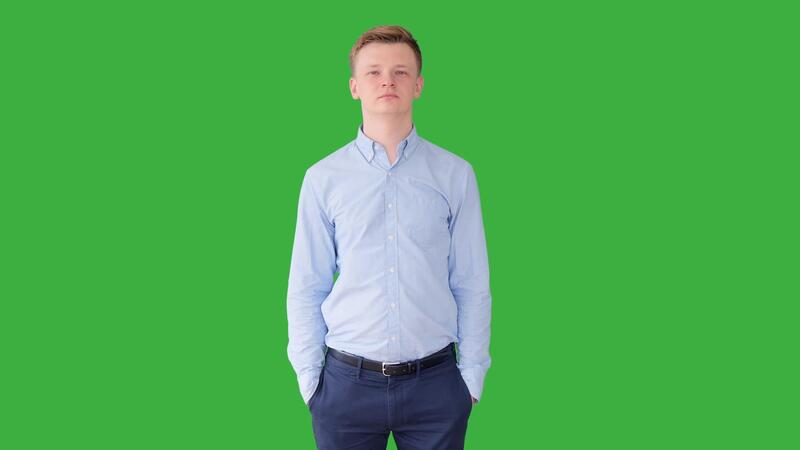

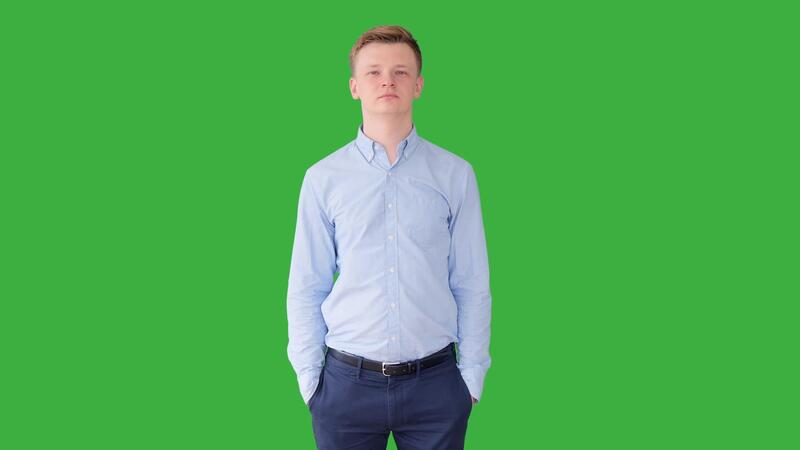

In [ ]:
import cv2
import numpy as np
import os
import tkinter as tk
from tkinter import filedialog, messagebox
from tkinter.ttk import Progressbar
from IPython.display import display, Video, Image as IPImage
from PIL import Image, ImageTk

def select_file(filetypes):
    root = tk.Tk()
    root.withdraw()
    filepath = filedialog.askopenfilename(title="Select a file", filetypes=filetypes)
    return filepath

def process_video(video_path, output_path='output_video.mp4', progress_callback=None):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error opening video file")
        return None

    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    ret, background = cap.read()
    if not ret:
        print("Error reading first frame")
        return None

    background_gray = cv2.cvtColor(background, cv2.COLOR_BGR2GRAY)
    h, w = background_gray.shape[:2]
    frame_idx = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        flow = cv2.calcOpticalFlowFarneback(
            background_gray, frame_gray, None,
            0.5, 5, 25, 5, 7, 1.5, 0
        )
        y, x = np.mgrid[0:h, 0:w].astype(np.float32)
        remap_x = x + flow[..., 0]
        remap_y = y + flow[..., 1]
        aligned_bg = cv2.remap(background, remap_x, remap_y, cv2.INTER_LINEAR)

        diff = cv2.absdiff(frame, aligned_bg)
        gray_diff = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
        gray_diff = cv2.GaussianBlur(gray_diff, (5, 5), 0)
        _, threshold = cv2.threshold(gray_diff, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        kernel = np.ones((7, 7), np.uint8)
        threshold = cv2.morphologyEx(threshold, cv2.MORPH_OPEN, kernel, iterations=2)
        threshold = cv2.morphologyEx(threshold, cv2.MORPH_CLOSE, kernel, iterations=3)

        contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        mask = np.zeros_like(threshold)
        for cnt in contours:
            if cv2.contourArea(cnt) > 500:
                cv2.drawContours(mask, [cnt], -1, 255, -1)

        mask = cv2.GaussianBlur(mask, (5, 5), 0)
        _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
        mask_inv = cv2.bitwise_not(mask)

        result = cv2.bitwise_and(aligned_bg, aligned_bg, mask=mask_inv)
        foreground = cv2.bitwise_and(frame, frame, mask=mask)
        final_output = cv2.add(result, foreground)
        out.write(final_output)

        if frame_idx % 10 == 0:
            background = cv2.bitwise_and(background, background, mask=mask_inv)
            new_bg_part = cv2.bitwise_and(frame, frame, mask=mask)
            background = cv2.add(background, new_bg_part)
            background_gray = cv2.cvtColor(background, cv2.COLOR_BGR2GRAY)

        frame_idx += 1
        if progress_callback:
            progress_callback(frame_idx, frame_count)

    cap.release()
    out.release()
    return output_path

def process_image(image_path, background_path, output_path="output_image.png"):
    frame = cv2.imread(image_path)
    background = cv2.imread(background_path)
    background = cv2.resize(background, (frame.shape[1], frame.shape[0]))

    # Create a background subtractor and apply on current image
    fg_bg = cv2.createBackgroundSubtractorMOG2(history=1, varThreshold=50, detectShadows=False)
    fg_mask = fg_bg.apply(background)  # train with background
    fg_mask = fg_bg.apply(frame)       # get mask from foreground

    # Clean up the mask
    kernel = np.ones((5, 5), np.uint8)
    fg_mask = cv2.morphologyEx(fg_mask, cv2.MORPH_OPEN, kernel, iterations=1)
    fg_mask = cv2.dilate(fg_mask, kernel, iterations=2)
    _, fg_mask = cv2.threshold(fg_mask, 127, 255, cv2.THRESH_BINARY)

    # Create inverse mask
    mask_inv = cv2.bitwise_not(fg_mask)

    # Extract foreground and background regions
    fg_part = cv2.bitwise_and(frame, frame, mask=mask_inv)
    bg_part = cv2.bitwise_and(background, background, mask=fg_mask)

    # Combine the background and foreground
    result = cv2.add(bg_part, fg_part)
    cv2.imwrite(output_path, result)
    return output_path


def run_app():
    def choose_action():
        action = tk.messagebox.askquestion("Choose Mode", "Do you want to process a video? (Click No for image)")
        if action == "yes":
            process_video_gui()
        else:
            process_image_gui()

    def process_video_gui():
        video_path = select_file([("Video files", "*.mp4 *.avi *.mov *.mkv")])
        if not video_path:
            messagebox.showwarning("No File", "Please select a video file.")
            return

        progress["maximum"] = 100
        status_label.config(text="Processing video...")

        def update_progress(current, total):
            percent = int((current / total) * 100)
            progress["value"] = percent
            window.update_idletasks()

        output_path = process_video(video_path, progress_callback=update_progress)
        status_label.config(text="Done!")
        messagebox.showinfo("Success", f"Processed video saved as: {output_path}")
        display(Video(output_path, embed=True))

    def process_image_gui():
        image_path = select_file([("Image files", "*.jpg *.png *.jpeg")])
        if not image_path:
            messagebox.showwarning("No File", "Please select a foreground image.")
            return
        background_path = select_file([("Image files", "*.jpg *.png *.jpeg")])
        if not background_path:
            messagebox.showwarning("No File", "Please select a background image.")
            return

        output_path = process_image(image_path, background_path)
        status_label.config(text="Done!")
        messagebox.showinfo("Success", f"Processed image saved as: {output_path}")
        display(IPImage(filename=output_path))

    window = tk.Tk()
    window.title("Invisibility Cloak Processor")
    window.geometry("400x250")

    tk.Label(window, text="Invisibility Cloak", font=("Helvetica", 16)).pack(pady=10)
    tk.Button(window, text="Start", command=choose_action, width=30).pack(pady=10)

    global progress
    progress = Progressbar(window, orient="horizontal", length=300, mode="determinate")
    progress.pack(pady=10)

    global status_label
    status_label = tk.Label(window, text="")
    status_label.pack()

    window.mainloop()

# Run the app
run_app()
